## Implementation of colorfulness and colorness filters to extract concept measures related to colors

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import PIL

from scipy import misc
import numpy as np
import argparse
import cv2

/home/mara/venv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(-0.5, 999.5, 666.5, -0.5)

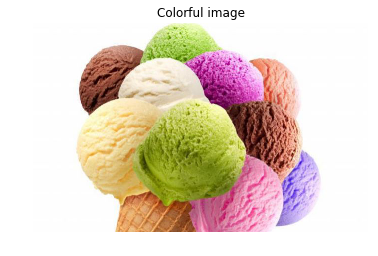

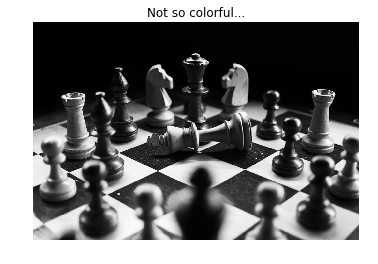

In [2]:
# Testing image: https://e00-expansion.uecdn.es/assets/multimedia/imagenes/2016/08/06/14704754832218.jpg
import requests
from io import BytesIO

url = 'https://e00-expansion.uecdn.es/assets/multimedia/imagenes/2016/08/06/14704754832218.jpg'
response = requests.get(url)
ice_cream_img = np.asarray(PIL.Image.open(BytesIO(response.content))) # colorful image
plt.imshow(ice_cream_img) 
plt.title('Colorful image')
plt.axis('off')

url = 'https://images.unsplash.com/photo-1528819622765-d6bcf132f793?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1000&q=80'
response = requests.get(url)
chess_img =  np.asarray(PIL.Image.open(BytesIO(response.content))) #not so colorful image
plt.figure()
plt.imshow(chess_img)
plt.title('Not so colorful...')
plt.axis('off')


In [3]:
def colorfulness(img):
    # split the image into its respective RGB components
    (B, G, R) = cv2.split(img.astype("float"))
 
    # compute rg = R - G
    rg = np.absolute(R - G)
 
    # compute yb = 0.5 * (R + G) - B
    yb = np.absolute(0.5 * (R + G) - B)
 
    # compute the mean and standard deviation of both `rg` and `yb`
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
 
    # combine the mean and standard deviations
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
 
    # derive the "colorfulness" metric and return it
    return stdRoot + (0.3 * meanRoot)

In [4]:
colorfulness(ice_cream_img)

68.9397189499684

In [27]:
colorfulness(chess_img)

0.0

In [59]:
## How much color is there? Ex. How much green, yellow or orange? 
# Colorness filter

def hsv_histograms(image):
    hist_hue = cv2.calcHist([image], [0], None, [180], [0, 180])
    hist_sat = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_val = cv2.calcHist([image], [2], None, [256], [0, 256])
    print np.mean(image[:,:,0])
    print np.min(image[:,:,0])
    print np.max(image[:,:,0])
    
    return hist_hue, hist_sat, hist_val

def color_picker(color_name):
    brg_colors={}
    brg_colors['red']= np.uint8([[[0,0,255 ]]])
    brg_colors['orange'] = np.uint8([[[0,128,255 ]]])
    brg_colors['yellow'] = np.uint8([[[0,255,255 ]]]) 
    brg_colors['green'] = np.uint8([[[0,255,0 ]]])
    brg_colors['cyano'] = np.uint8([[[255,255,0 ]]])
    brg_colors['blue'] = np.uint8([[[255,0,0]]])
    brg_colors['purple'] = np.uint8([[[255,0,128]]])
    brg_colors['magenta'] = np.uint8([[[255,0,255 ]]])
    brg_colors['white'] = np.uint8([[[255,255,255 ]]])
    brg_colors['black'] = np.uint8([[[0,0,0 ]]])
    
    rgb_color_code = brg_colors[color_name]
    return cv2.cvtColor(rgb_color_code,cv2.COLOR_BGR2HSV)

def round_hue(hue_val):
    hues = np.arange(0,180)
    if hue_val<180:
        hue_def = hues[hue_val]
    else:
        hue_def = hues[(hue_val)%179]
    return hue_def

def quantize_hue_ranges(image, color_name):
    if color_name == 'red':
        hue_min = 165
        hue_max = 10
    
    elif color_name == 'orange':
        hue_min = 10
        hue_max = 25
    elif color_name == 'yellow':
        hue_min = 25
        hue_max = 40
    elif color_name == 'green':
        hue_min = 40
        hue_max = 75
    elif color_name == 'cyano':
        hue_min = 75
        hue_max = 100
    elif color_name == 'blue':
        hue_min = 100
        hue_max = 125
    elif color_name == 'purple':
        hue_min = 125
        hue_max = 145
    elif color_name == 'magenta':
        hue_min = 145
        hue_max = 165
    elif (color_name == 'white' or color_name == 'black'):
        hue_min = 0
        hue_max = 255
        
    return hue_min, hue_max

def colorness(image, color_name, threshold = 0, verbose=False):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    #plt.imshow(image)
    if verbose:
        h,s,v = hsv_histograms(image)
        plt.figure()
        plt.plot(h)
        plt.figure()
        plt.plot(s)
        plt.figure()
        plt.plot(v)
    
    if threshold == 0: 
        hue_min, hue_max = quantize_hue_ranges(image, color_name)
        if verbose:
            print 'hue min, hue max: ', hue_min, hue_max
    else: 
        h_point =color_picker(color_name)
        hue_min = round_hue(h_point[0][0][0]-threshold)
        hue_max = round_hue(h_point[0][0][0]+threshold)
        if verbose:
            print 'hue min, hue max: ', hue_min, hue_max
    '''
    if verbose:
        print 'red', color_picker(brg_colors['red'])
        print 'orange', color_picker(brg_colors['orange'])
        print 'yellow', color_picker(brg_colors['yellow'])
        print 'green', color_picker(brg_colors['green'])
        print 'cyano', color_picker(brg_colors['cyano'])
        print 'blue', color_picker(brg_colors['blue'])
        print 'purple', color_picker(brg_colors['purple'])
        print  'magenta', color_picker(brg_colors['magenta'])
    '''
    if (hue_min == hue_max == 0) or (hue_min == 0 and hue_max == 255): 
        #it is either black or white
        if color_name=='black':
            low_c = np.array([0,
                              0,
                              0])
            upp_c = np.array([hue_max,
                              100,
                              100])
        if color_name=='white':
            low_c = np.array([0,
                              0,
                              190])
            upp_c = np.array([hue_max,
                              50,
                              255])
        
        if verbose:        
            print 'low_c', low_c, 'upp_c', upp_c

        mask = cv2.inRange(image, low_c, upp_c)
        
    elif hue_min>hue_max:
        low_c = np.array([0,
                      50,
                      77])
        upp_c = np.array([hue_max,
                      255,
                      255])
        mask1 = cv2.inRange(image, low_c, upp_c)
        
        low_c = np.array([hue_min,
                      50,
                      77])
        upp_c = np.array([180,
                      255,
                      255])
        mask2 = cv2.inRange(image, low_c, upp_c)
        
        mask = cv2.bitwise_or(mask1, mask1, mask2)
    
    else:
        low_c = np.array([hue_min,
                          50,
                          77])
        upp_c = np.array([hue_max,
                          255,
                          255])
        if verbose:        
            print 'low_c', low_c, 'upp_c', upp_c

        mask = cv2.inRange(image, low_c, upp_c)
    if verbose:
        print mask
   
    res = cv2.bitwise_and(image, image, mask = mask)
    if verbose:
        plt.figure()
        plt.imshow(mask, cmap='Greys')
        plt.colorbar()

        plt.figure()
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_HSV2RGB))
        plt.figure()
        plt.imshow(cv2.cvtColor(res, cv2.COLOR_HSV2RGB))
    
    #print np.sum(mask==255)
    x,y,z = image.shape
    print x, y , z
    if verbose:
        print np.sum(mask==255)/(float(x)*float(y))
    
    return float(np.sum(mask==255))/(float(x)*float(y))

def get_color_mask(image, color_name, threshold=0, verbose=False):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    
    if threshold == 0: 
        hue_min, hue_max = quantize_hue_ranges(image, color_name)
        if verbose:
            print 'hue min, hue max: ', hue_min, hue_max
    else: 
        h_point =color_picker(color_name)
        hue_min = round_hue(h_point[0][0][0]-threshold)
        hue_max = round_hue(h_point[0][0][0]+threshold)
        if verbose:
            print 'hue min, hue max: ', hue_min, hue_max
    '''
    if verbose:
        print 'red', color_picker(brg_colors['red'])
        print 'orange', color_picker(brg_colors['orange'])
        print 'yellow', color_picker(brg_colors['yellow'])
        print 'green', color_picker(brg_colors['green'])
        print 'cyano', color_picker(brg_colors['cyano'])
        print 'blue', color_picker(brg_colors['blue'])
        print 'purple', color_picker(brg_colors['purple'])
        print  'magenta', color_picker(brg_colors['magenta'])
    '''
    if (hue_min == hue_max == 0) or (hue_min == 0 and hue_max == 255): 
        print 'black or white', color_name
        #it is either black or white
        if color_name=='black':
            print 'in black'
            low_c = np.array([0,
                              0,
                              0])
            upp_c = np.array([hue_max,
                              100,
                              100])
        if color_name=='white':
            print 'in white'
            low_c = np.array([0,
                              0,
                              190])
            upp_c = np.array([hue_max,
                              50,
                              255])
            
        mask = cv2.inRange(image, low_c, upp_c)
        return mask
    if hue_min>hue_max:
        low_c = np.array([0,
                      50,
                      77])
        upp_c = np.array([hue_max,
                      255,
                      255])
        mask1 = cv2.inRange(image, low_c, upp_c)
        
        low_c = np.array([hue_min,
                      50,
                      77])
        upp_c = np.array([180,
                      255,
                      255])
        mask2 = cv2.inRange(image, low_c, upp_c)
        
        mask = cv2.bitwise_or(mask1, mask1, mask2)
    
    else:
        low_c = np.array([hue_min,
                          50,
                          77])
        upp_c = np.array([hue_max,
                          255,
                          255])
        if verbose:        
            print 'low_c', low_c, 'upp_c', upp_c

        mask = cv2.inRange(image, low_c, upp_c)
    if verbose:
        print mask
    return mask

def image_colors(image, threshold=0):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    x,y,z = image.shape
    new_image = np.ones((x,y,3), dtype='uint8')*255
    #print new_image
    #new_image = cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB)
    #plt.imshow(new_image)
    #new_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    colors = ['black', 'white', 'red', 'orange','yellow', 'green', 'cyano', 'blue', 'purple', 'magenta']
    #plt.imshow(image)

    for c in colors:
        #print c
        color_mask = get_color_mask(image, c, threshold=threshold)
        #plt.figure()
        #plt.imshow(color_mask)
        #print color_mask
        #plt.figure()
        #plt.title(c)
        #new_image =  cv2.cvtColor(new_image,cv2.COLOR_RGB2HSV)
        new_image = recolor(new_image, color_mask, c)
        #new_image =  cv2.cvtColor(new_image,cv2.COLOR_HSV2RGB)
        #plt.imshow(new_image)
        #plt.figure()
        #plt.imshow(color_mask)
        
        #
    new_image =  cv2.cvtColor(new_image,cv2.COLOR_HSV2RGB)  
    plt.figure()
    plt.imshow(new_image)
    #print new_image
    return new_image

def recolor(image, color_mask, color_name):
    color_hues = {}
    color_hues['red']=5
    color_hues['orange']=15
    color_hues['yellow']=30
    color_hues['green']=50
    color_hues['cyano']=90
    color_hues['blue']=120
    color_hues['purple']=140
    color_hues['magenta']=160
    color_hues['black']=0
    color_hues['white']=0
    
    if color_name == 'black':
        image[color_mask==255] = (0,0,0)

    elif color_name == 'white':
        image[color_mask==255] = (0,0,255)
    else:
        #print image[color_mask==255].shape
        image[color_mask==255] = (color_hues[color_name],255,255)
        #print image.shape

        #plt.imshow(image)
    return image
        

34.10059700438039
0
179
hue min, hue max:  0 255
low_c [  0   0 190] upp_c [255  50 255]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
420 674 3
0.49584569732937683


0.49584569732937683

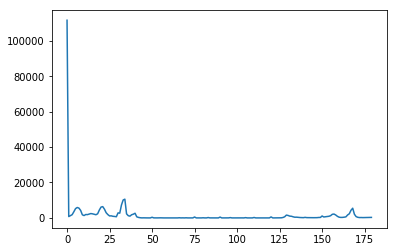

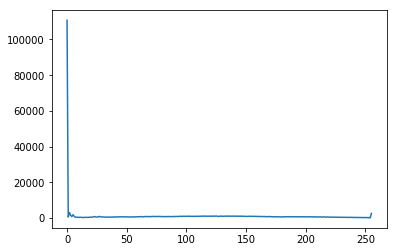

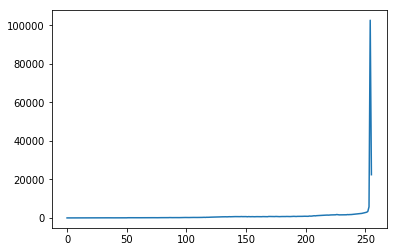

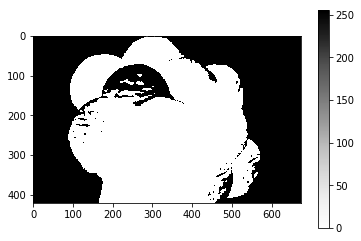

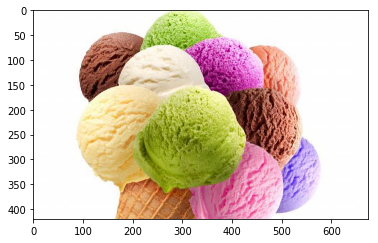

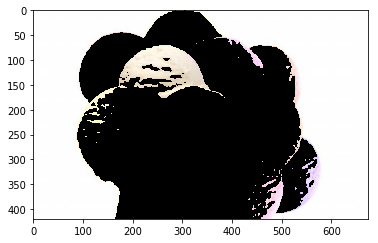

In [60]:
colorness(cv2.cvtColor(ice_cream_img,cv2.COLOR_RGB2BGR) , 'white', threshold = 0, verbose=True)

0.0
0
0
hue min, hue max:  0 255
low_c [  0   0 190] upp_c [255  50 255]
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]
667 1000 3
0.1604527736131934


0.1604527736131934

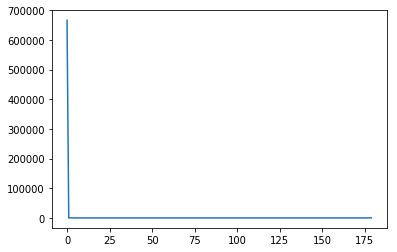

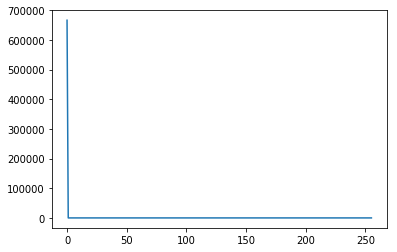

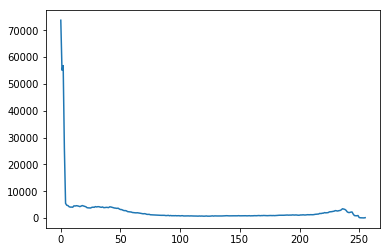

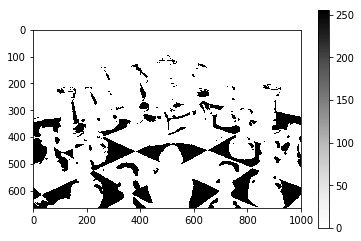

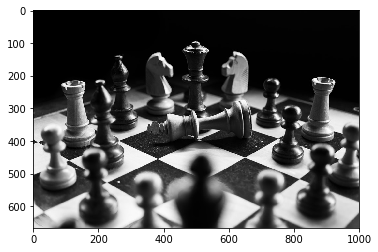

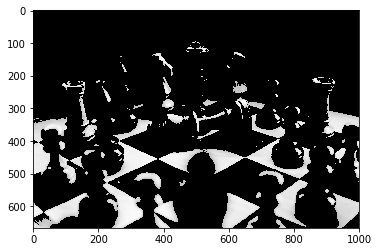

In [61]:
colorness(cv2.cvtColor(chess_img,cv2.COLOR_RGB2BGR) , 'white', threshold = 0, verbose=True)